In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.api as sm
import scipy.spatial
from matplotlib import pyplot
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from scipy.spatial.distance import hamming, pdist, squareform
from sklearn.metrics import jaccard_score

In [106]:
df = pd.read_parquet("wbmasterf.parquet")

In [107]:
legend = df.groupby(["child_id"]).first()[["ageg", "sex", "production", "age"]].reset_index()

In [108]:
df["child_id"].nunique()

4831

In [109]:
legend.shape

(4831, 5)

# **Part 4A: Evaluating the recommendation model**

Since we are no longer segmenting our data, our user-item matrix will include the interaction history of *all* existing users, across age and sex. Our EDA revealed that there are significant differences in the quality and quantity of the vocabulary of children, depending on their age and sex. Therefore, by inputting the information of a user, our model should be able to approximate their age and sex. 

While the goal of the model is of course not to predict a user's demographic characteristics, it *is* important to ensure that the recommended items do take the child's current developmental stage into consideration. For age-appropriate items to be recommended to the user, our model should (overall) be identifying users of a similar age to our target user as neighbours.

## Segmenting data, 80/20 split

First, I will extract 20% of children per possible age/sex combination. Want to take demographics because important to ensure effective for all users.

In [110]:
testusers = df.drop_duplicates(subset="child_id")
testusers.shape

(4831, 9)

In [111]:
testusers = testusers.groupby(["ageg", "sex"])["child_id"].sample(frac=0.2)
testusers.shape

(967,)

Create a new df with only the information of our chosen test users; remove the test users from our "training data".

In [112]:
mask = df["child_id"].isin(testusers)
testdata = df[mask]

In [113]:
df = df[~mask]
df["child_id"].nunique()

3864

Prep stuff:

In [114]:
user_item_matrix = df.pivot(index="child_id", columns="item_id", values="value")
itemsorted = sorted(user_item_matrix.columns, key=lambda x: int(x.split("_")[1]))
user_item_matrix = user_item_matrix[itemsorted]
user_item_matrix.columns = [f"item_{int(col.split('_')[1]) - 1}" if col.startswith("item_") else col for col in user_item_matrix.columns]
target_item_matrix = user_item_matrix.T
itemsim = (scipy.spatial.distance.cdist(target_item_matrix.values, target_item_matrix.values, metric='jaccard'))
knn = NearestNeighbors(n_neighbors=5, metric='jaccard', algorithm='brute')
knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='jaccard')

In [115]:
def collect_interaction_history(testusers):
    interaction_history = {}
    for user in testusers:
        user_interactions = testdata[testdata["child_id"] == user]["value"].tolist()
        distance, neighbor_indices = knn.kneighbors([user_interactions])
        neighbor_indices = neighbor_indices[0]
        neighbor_id = user_item_matrix.index[neighbor_indices]
        neighbors_info = legend[legend["child_id"].isin(neighbor_id)][["child_id", "ageg", "sex"]]
        interaction_history[user] = distance, neighbor_id, neighbors_info
        
#neighbor stats still correct up until this point

    data = []
    for user, (distance, neighbor_id, neighbors_info) in interaction_history.items():
        user_sex = legend[legend["child_id"] == user]["sex"].iloc[0]
        user_age = legend[legend["child_id"] == user]["ageg"].iloc[0]

# below is where neighbor ids get jumbled up. ids plus neighbour stats are still associated with correct test 
# users though, so should be no problem for calcualting the mode. just within test users, ids dont line up 
# anymore with the correct info. fix if time.

        for i in range(len(neighbor_id)):
            data.append([user, neighbor_id[i], user_age, neighbors_info.iloc[i]["ageg"], user_sex, neighbors_info.iloc[i]["sex"], distance[0][i]])

    # Create a DataFrame from the collected data
    columns = ["User_ID", "Neighbor_ID", "User_Age", "Neighbor_Age", "User_Sex", "Neighbor_Sex", "Dissimilarity_Score"]
    result_df = pd.DataFrame(data, columns=columns)

    return result_df

In [116]:
result_df = collect_interaction_history(testusers)

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

Running the function returns **`result_df`**, containing demographic information for all of the 5 found neighbours of each test user, and also the test users themselves.

In [117]:
result_df

,User_ID,Neighbor_ID,User_Age,Neighbor_Age,User_Sex,Neighbor_Sex,Dissimilarity_Score
0,1274,867,1,1,Female,Female,0.543860
1,1274,62833,1,1,Female,Male,0.597222
2,1274,86255,1,4,Female,Female,0.597403
3,1274,85168,1,2,Female,Male,0.603448
4,1274,1385,1,1,Female,Male,0.606061
...,...,...,...,...,...,...,...
4830,3300,3499,5,5,Male,Female,0.026706
4831,3300,3446,5,5,Male,Male,0.030928
4832,3300,3353,5,5,Male,Male,0.030928
4833,3300,3425,5,5,Male,Male,0.030928


For each user, the average dissimilarity score across all neighbours:

In [118]:
dismean = result_df.groupby("User_ID")["Dissimilarity_Score"].mean().reset_index()

"Vote" for a final prediction for each test user's age group and sex by finding the mode of their 5 neighbours. Put the results together in a df with each user's actual stats.

In [119]:
# kind of umständlich, fix

predicted_age_sex = result_df.groupby("User_ID")[["Neighbor_Age", "Neighbor_Sex"]].agg(lambda x: x.mode().iloc[0])

true_info = legend[["child_id", "ageg", "sex"]]

finalpred = predicted_age_sex.merge(true_info, left_index=True, right_on="child_id")

finalpred = finalpred.merge(dismean, left_on="child_id", right_on="User_ID")

finalpred = finalpred.rename(columns={"ageg": "true_age", "sex": "true_sex", "Neighbor_Age": "predicted_age", "Neighbor_Sex": "predicted_sex"})

finalpred["agetrue"] = finalpred["true_age"] == finalpred["predicted_age"]
finalpred["sextrue"] = finalpred["true_sex"] == finalpred["predicted_sex"]

finalpred = finalpred.drop(columns="child_id")

finalpred = finalpred.reset_index(drop=True)
finalpred = finalpred[["User_ID", "true_age", "predicted_age", "true_sex", "predicted_sex", "agetrue", "sextrue", "Dissimilarity_Score"]]
finalpred = finalpred.sort_values(["true_age", "true_sex"])
finalpred

,User_ID,true_age,predicted_age,true_sex,predicted_sex,agetrue,sextrue,Dissimilarity_Score
9,35,1,2,Female,Male,False,False,0.641767
55,247,1,1,Female,Male,True,False,0.820162
64,275,1,1,Female,Male,True,False,0.556667
72,308,1,2,Female,Male,False,False,0.661356
77,327,1,2,Female,Female,False,True,0.552232
...,...,...,...,...,...,...,...,...
949,86540,5,3,Male,Male,False,True,0.238794
954,86557,5,5,Male,Male,True,True,0.187542
956,86566,5,5,Male,Male,True,True,0.174292
958,86578,5,3,Male,Female,False,False,0.301806


In [120]:
#with 5 neighbors
print("\033[1mSummary:\033[0m")
print()
print("Number of correct predictions for AGE:", finalpred["agetrue"].sum(),"/",len(testusers),"- Accuracy:",finalpred["agetrue"].sum()/len(testusers))
print("Number of correct predictions for SEX:", finalpred["sextrue"].sum(),"/",len(testusers),"- Accuracy:",finalpred["sextrue"].sum()/len(testusers))

Summary:

Number of correct predictions for AGE: 407 / 967 - Accuracy: 0.42088934850051707
Number of correct predictions for SEX: 633 / 967 - Accuracy: 0.6546018614270941


Not necessarily amazing results, but for **`ageg`** (age group) we have to keep in mind that a prediction of `2` for a target user belonging to age group `1` is not "as wrong" as a prediction of `5` would be. A binary true or false metric doesn't provide detailed information on the accuracy of the predictions.

Also, predictions were calculated using the mode of the neighbours, without taking their respective similarity scores into account. Ideally, demographic data stemming from neighbours rated as highly similar to the user would be weighted more heavily than that from neighbours with lower similarity.

The sample size for each group is also relatively small and not the same across all ages and sexes, which could also explain why (when having a thorough look at **`ageg`**) the age of users belonging to age group `5` is guessed very accurately in comparison to others. During our EDA, we found that this group has the highest n. Additionally, this age group is the most likely to have interacted with items that all other age groups have not. This means they will have more overlapping interactions that are unique to this specific age group, unlike age group `1` for example, whose limited interactions i.e. limited vocabulary will consist of words that users of *all* age groups have also already learned.

Sex differences in vocabulary are also not uniform across all age groups (sex x age interaction term of anova, plus top 5 categories by age and sex). For certain age groups, they are more pronounced, and for others non-existent, hence it might be easier to discriminate between **`sex`** for specific age groups. 

Also note that much variation in vocabulary can exist even between children who are of the same age. A lingusitically "gifted" user's interaction history will be more closely associated with age groups above its own, rather than its own.

## Dissimilarity scores and sample sizes

Some plots to explore the idea that the prediction accuracy for the age group of `5` might be so high in comparison to others due to the large size of the sample.

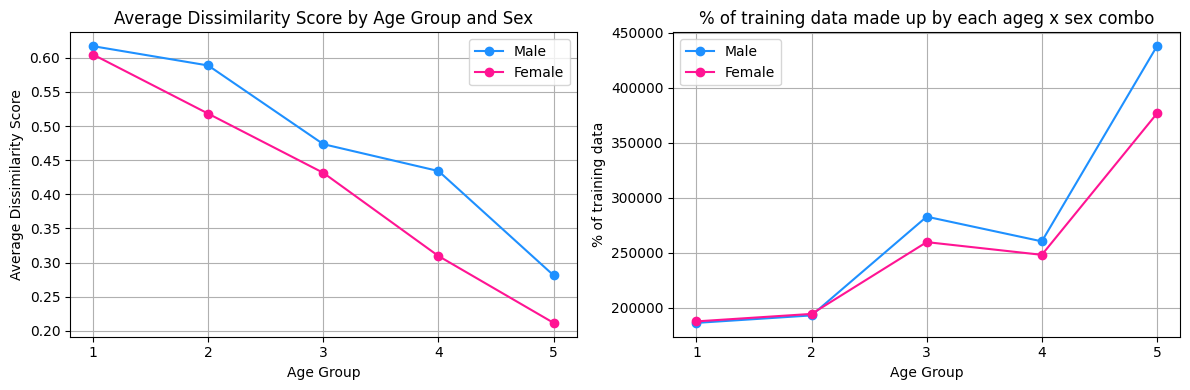

In [121]:
grouped_data = finalpred.groupby(["true_age", "true_sex"])["Dissimilarity_Score"].mean().unstack()
tots = df.groupby(['ageg', 'sex'])['ageg'].count().unstack()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(grouped_data.index, grouped_data["Male"], marker="o", label="Male", linestyle="-", color="dodgerblue")
ax1.plot(grouped_data.index, grouped_data["Female"], marker="o", label="Female", linestyle="-", color="deeppink")

ax1.set_title('Average Dissimilarity Score by Age Group and Sex')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Dissimilarity Score')
ax1.set_xticks(grouped3.index)
ax1.legend()
ax1.grid()

ax2.plot(tots.index, tots["Male"], marker="o", label="Male", linestyle="-", color="dodgerblue")
ax2.plot(tots.index, tots["Female"], marker="o", label="Female", linestyle="-", color="deeppink")

ax2.set_title('% of training data made up by each ageg x sex combo')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('% of training data')
ax2.set_xticks(grouped3.index)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

## Accuracies by age x sex combos

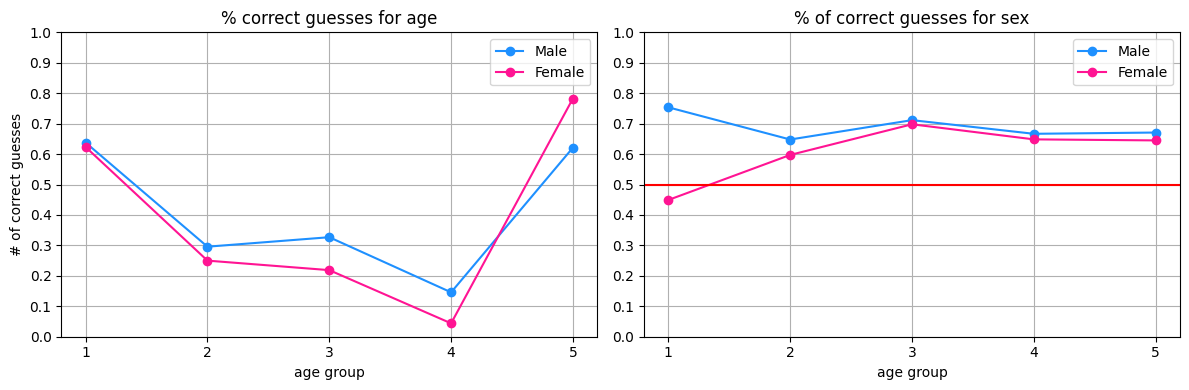

In [122]:
grouped2 = finalpred.groupby(["true_age", "true_sex"])["agetrue"].mean().unstack()
grouped3 = finalpred.groupby(["true_age", "true_sex"])["sextrue"].mean().unstack()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(grouped2.index.astype(str), grouped2["Male"], marker="o", label="Male", color="dodgerblue")
ax1.plot(grouped2.index.astype(str), grouped2["Female"], marker="o", label="Female", color="deeppink")

ax1.set_title("% correct guesses for age")
ax1.set_xlabel("age group")
ax1.set_ylabel("# of correct guesses")
ax1.set_xticks(grouped2.index)
ax1.set_yticks(np.arange(0, 1.1, 0.1))

ax1.grid()
ax1.legend()

ax2.plot(grouped3.index.astype(str), grouped3["Male"], marker="o", label="Male", color="dodgerblue")
ax2.plot(grouped3.index.astype(str), grouped3["Female"], marker="o", label="Female", color="deeppink")
ax2.axhline(y=0.5, color='r', linestyle='-')

ax2.set_title("% of correct guesses for sex")
ax2.set_xlabel("age group")
ax2.set_xticks(grouped3.index)
ax2.set_yticks(np.arange(0, 1.1, 0.1))

ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

## Confusion matrix

Wrong predictions made for 2 and 4 are actually not that off.

might be a little bit biased towards predicting 5.

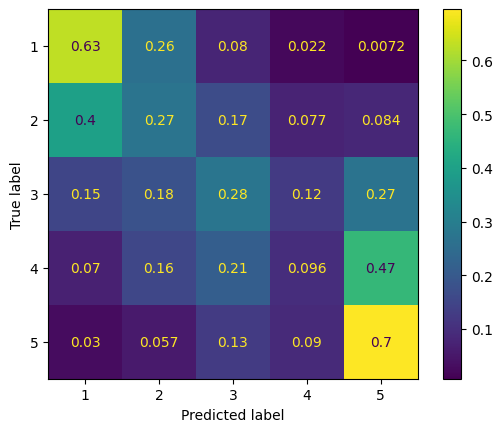

In [123]:
confusion_matrix = metrics.confusion_matrix(finalpred["true_age"], finalpred["predicted_age"])
confusion_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [1,2,3,4,5])

cm_display.plot()
plt.show()